# NetSciX 2026

# Inferential approach using SBMs

Inferential approaches specify the probability of the data being genereated by a network model and use computational methods to infer the best networks or parameters. Here we will use the Stochastic Block Models (SBM) family of random graphs to identify meso-scale structures in networks. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

gk = nx.karate_club_graph()
layout = nx.spring_layout(gk)
N=gk.number_of_nodes()

## 1 The SBM likelihood of a partition

 We will start computing best partitions of the $N$ nodes in a network into an arbitrary number $B$ of blocks. We will then consider the selection of best $B$ based on Bayesian model comparison.

As derived in class, the negative log-likelihood of a SBM generating a given network can be written as

$$ -\log(L) = - \sum_{r,s} \ell_{r,s} \log \frac{\ell_{r,s}}{y_{r,s}} +(y_{r,s}-\ell_{r,s}) \log (1-\frac{\ell_{r,s}}{y_{r,s}}),$$

where $\ell_{r,s}$ is the number of edges betwen blocks $r,s$ and $y_{r,s}$ is the maximum posisble number of links. Below we implement this function for partitions of arbitrary number of groups $1 \le B \le N$.

In [2]:
def likelihoodLY(L,Y):
    ''' Compute the negative log-likelihood of the SBM model, given the block matrices of edges L and maximum edges Y'''
    logL=0
    B=len(L)
    for r in range(B):
        for s in np.arange(r+1):
            #print(r,s,L[r][s],Y[r][s],logL)
            if L[r][s]>0:
                logL+=-L[r][s]*np.log(L[r][s]/Y[r][s])
            if L[r][s]<Y[r][s]:
                logL+=-(Y[r][s]-L[r][s])*np.log(1-L[r][s]/Y[r][s])
    return logL

def minusLogLB(gs,bp):
    ''' Compute the negative log-likelihood for the SBM model, given the network gs and block allocation bp'''
    
    #Number of nodes
    N=len(bp)
    B=int(np.max(bp)+1) # number of blocks in partition bpar
    Ns=[bp.count(i) for i in range(B)] #number of nodes in each partition
    
    # Create dictionary with allocation
    b={}
    for r in range(N):
        b[r]=bp[r]
    
    # Matrices of edges and total possible edges
    #Initialization as empty matrix
    rows, cols = B, B
    Ls = [[0 for _ in range(cols)] for _ in range(rows)]
    Ys = [[0 for _ in range(cols)] for _ in range(rows)]

    #Fill the matrix of edges L
    for e in gs.edges():
        if b[e[1]]<b[e[0]]:
            Ls[b[e[0]]][b[e[1]]]+=1
        else:
            Ls[b[e[1]]][b[e[0]]]+=1    

    # Compute the matrix of the maximum possible edges Y
    for r in range(B):
        for s in np.arange(r+1):
            if r!=s:
                Ys[r][s]=Ns[r]*Ns[s]
            else:
                Ys[r][s]=Ns[r]*(Ns[s]-1)/2.
                
    return likelihoodLY(Ls,Ys)

We can compute the loglikelihood of the club partition in the Karate Club network as:

198.4993674245292


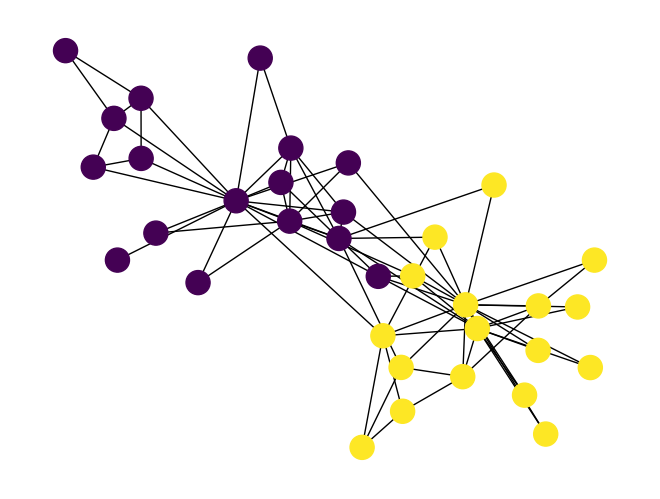

In [3]:
gk = nx.karate_club_graph()
layout = nx.spring_layout(gk)
N=gk.number_of_nodes()

partClub=[]
for i in range(N):
    if gk.nodes[i]['club']=="Mr. Hi":
        partClub.append(0)
    else:
        partClub.append(1)

print(minusLogLB(gk,partClub))
nx.draw(gk,pos=layout,node_color=partClub)

## 2 Finding good partitions for a given B

We are now interested in finding the best SBM block allocation for an arbitrary (fixed) $B$. Again, we generalize the greedy algorithm used previously.

In [4]:
def bestB(g,B):
    '''Searches the best partitions of network g in B groups according to the SBM, using a greedy approach'''
    N=g.number_of_nodes()
    bstart=[np.random.randint(B) for i in range(N)]
    bbest=bstart[:]

    bestL=minusLogLB(gk,bbest)
    flag=0

    j=0
    while flag==0 and j<=N**2: # we stop if no improvement is found or if we tried for a long time.
        bestL=minusLogLB(g,bbest)
        iflip=-1
        rflip=-1
        for i in range(N): #search over all nodes the best flip
            bt=bbest[:]
            for r in range(B): #search over all possible flips of the block allocation of node i
                bt[i]=r
                tempL=minusLogLB(g,bt)
                if(tempL<bestL):
                   # print("Found better by fliping",i," to ",r,"leading to ",tempL)
                    iflip=i
                    rflip=r
                    bestL=tempL
        if iflip>-1:
            bbest[iflip]=rflip
            bestL=minusLogLB(g,bbest)
        else:
            flag=1
        j+=1
    return(bestL,bbest)


def bestBrepeat(g,B=2,R=10):
    '''Searches the best partitions of network g in B groups according to the SBM, using a greedy approach. Returns best of R tries.'''
    bestL=np.inf
    bestb=[]
    for r in range(R): # Repeat the greedy search R times 
        testL,testb=bestB(g,B)        
        if testL<bestL:
            bestL=testL
            bestb=testb
    return(bestL,bestb)

We can test the code by checking if we retrieve the previous best partition with $B=2$ in the Karate Club network:

Best Karate-Club partition with B=2, with logL=179.3891968406941


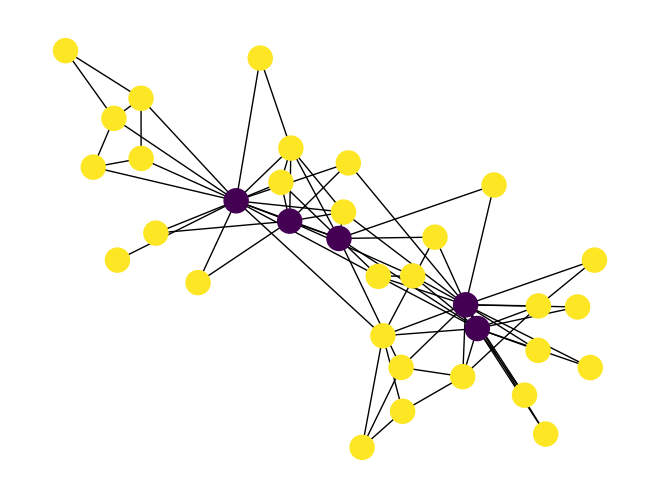

In [5]:
Bf=2
logLB,bbestB=bestBrepeat(gk,Bf)
print("Best Karate-Club partition with B="+str(Bf)+", with logL="+str(logLB))
nx.draw(gk,pos=layout,node_color=bbestB)

### Questions: 

- What type of structure is this: Assortative, Disassortative, or core-periphery?
- From an SBM point of view, which partition is more likely: the one above or the Club partition?


## 3 Model comparison for different $B$'s

As discussed in class, we will compare SBMs with partitions $\vec{b}$ with different number of groups $B$ (unique groups in $\vec{b}$) using a Bayesian approach 

$$P(\vec{b}|D) \propto P(D|\vec{b})P(\vec{b}|B) P(B).$$

We take flat (uninformative) prior probabilities by giving first the same probability for all possible $B$'s in $B=1, \ldots, N$

$$P(B) = 1/N.$$ 

Similarly, for a given $B$, the probability of any partition is taken to be the same and therefore

$$P(\vec{b}|B) = \frac{1}{B!\left\{ \begin{matrix} N \\ B \end{matrix} \right\}},$$

where 

$$ S(N,B)=\left\{ \begin{matrix} N \\ B \end{matrix} \right\}$$

is the [Stirling numbers of second kind](https://en.wikipedia.org/wiki/Stirling_numbers_of_the_second_kindPriors) and counts the number of unique partitions of $N$ nodes in $B$ non-empty groups. Since $N$ and $P(D)$ are constant in the inference, we can write 

$$\log P(\vec{b}|D) = \log(P(D|\vec{b})) +\log(P(\vec{b}|B)) + \text{ constant. }$$

In this approach, complex models are penalized by the prior that accounts for the combinatorial growth of possible partitions as $B$ grows. This highlights the importance of accounting for the number of possible re-labeling of community assignments, accounted by the $B!$ term in the above prior. For instance, $B=N$ we have $\left\{ \begin{matrix} N \\ B \end{matrix} \right\}=1$ and the $B!$ term is essential to account for the model complexity.

In [6]:
from sympy.functions.combinatorial.numbers import stirling
from scipy.special import factorial

## 4 Application to Synthetic Data

Aveage Degree:6.5


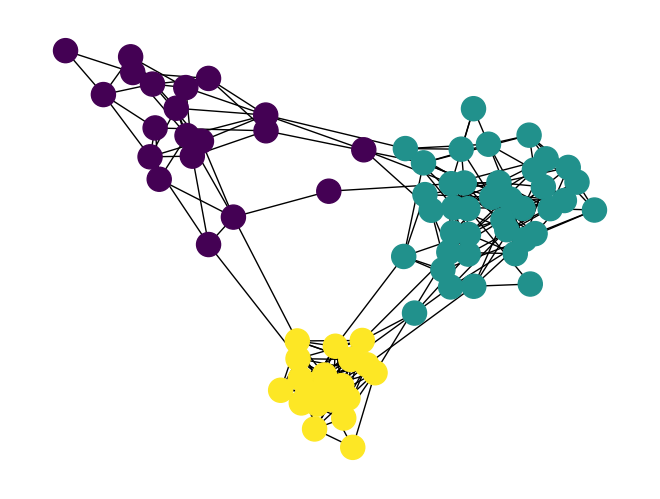

In [7]:
sizes = [20,40,20] #[N0,N1,N2]
q=0.01
p = [[0.2, q, q], [q, 0.15,q],[q,q,0.5]]  # intra- and inter-community connection probabilities
Gsbm = nx.stochastic_block_model(sizes, p,seed=13)

# True partion in 3 blocks
btrue3=[]
for n in range(len(sizes)):
    for i in range(sizes[n]):
        btrue3.append(n)

layoutSBM = nx.spring_layout(Gsbm,seed=8)
print("Aveage Degree:"+str(2*Gsbm.number_of_edges()/Gsbm.number_of_nodes()))
#print("Ground truth partition, with -log L ="+str(minusLogLB(Gsbm,btrue3)))
nx.draw(Gsbm,node_color=btrue3,pos=layoutSBM)

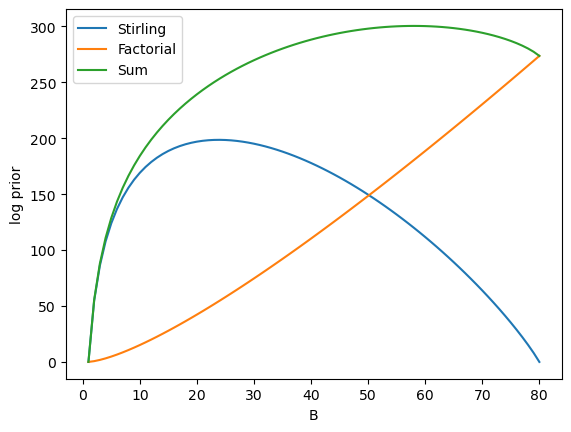

In [8]:
N=Gsbm.number_of_nodes()
logPriors = [np.log(float(stirling(N,k+1,kind=2))) for k in range(N)]
logFactorial=[np.log(factorial(k+1)) for k in range(N)]

plt.plot(np.arange(1,N+1),logPriors,label="Stirling")
plt.plot(np.arange(1,N+1),logFactorial,label="Factorial")
plt.plot(np.arange(1,N+1),np.array(logPriors)+np.array(logFactorial),label="Sum")
plt.xlabel("B")
plt.ylabel("log prior")
plt.legend()
plt.show()

### Synthetic SBM data

In [9]:
logLs,bbests = [],[]
Bmax= 7

try:
    logLs = np.load("SBMlogLs.npy")
    bbests = np.load("SBMbbests.npy")

except:    
    for Bf in np.arange(1,Bmax+1):
        print("Running B=",Bf," out of ",Bmax)
        logLB,bbestB=bestBrepeat(Gsbm,Bf)
        logLs.append(logLB)
        bbests.append(bbestB)
    np.save("SBMlogLs.npy",logLs)
    np.save("SBMbbests.npy",bbests)

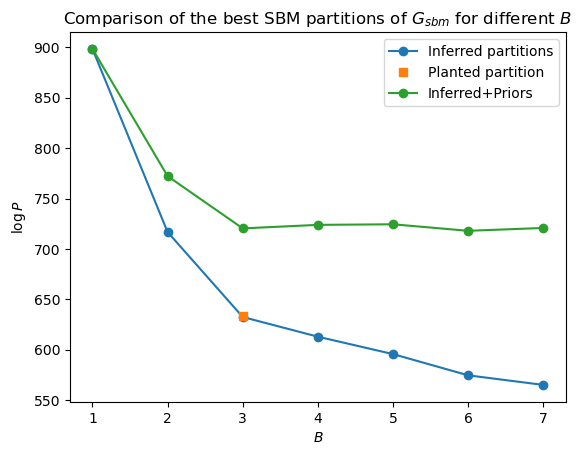

In [10]:
plt.plot(np.arange(1,Bmax+1),logLs,"-o",label="Inferred partitions")
plt.plot([3],[minusLogLB(Gsbm,btrue3)],"s",label="Planted partition")
plt.plot(np.arange(1,Bmax+1),np.array(logLs)+logFactorial[:Bmax]+logPriors[:Bmax],"-o",label="Inferred+Priors")
plt.ylabel(r"$\log P$")
plt.xlabel(r"$B$")
plt.title(r"Comparison of the best SBM partitions of $G_{sbm}$ for different $B$")
#plt.ylim(600,720)
plt.legend()
plt.show()

Inferred network with true B. Inferred logL=632.5068551301305 True logL=633.8973885886735


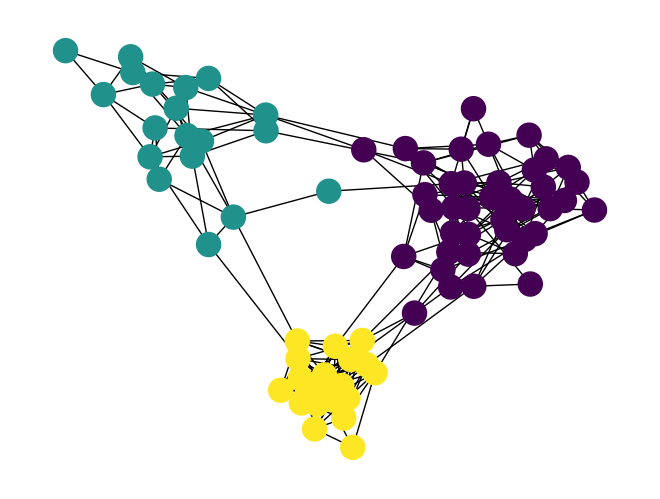

In [11]:
print("Inferred network with true B. Inferred logL="+str(logLs[2])+" True logL="+str(minusLogLB(Gsbm,btrue3)))
nx.draw(Gsbm,node_color=bbests[2],pos=layoutSBM)

### Questions: 

- Is the inferred community with $B=3$ equal to the planted ones? Why?
- Plot the best $B=4$ partition and compare it to the $B=3$ one. Explain your observations.
- Consider a Poisson random graph (Erdos-Renyi) with $N=100$ nodes and average degree $5$. What is the optimal $B$ inferred from the SBM approach proposed above?

## SBMs using Graph-Tool

The Python package [graph-tool](https://graph-tool.skewed.de/) has different variations of SBMs and optimization methods, and is recommended for efficient computational analysis. A review of the methods and models can be found in [Bayesian stochastic blockmodeling](https://arxiv.org/abs/1705.10225) (by Tiago P. Peixoto). 

Graph-tool can **not** be installed via "pip install", follow instead the instructions [here](https://graph-tool.skewed.de/installation.html).

In [15]:
import graph_tool.all as gt

In [16]:
g=gt.collection.data["polblogs"]
print("N=", g.num_vertices(), "L=", g.num_edges())

N= 1490 L= 19090


### Political blog analysis from

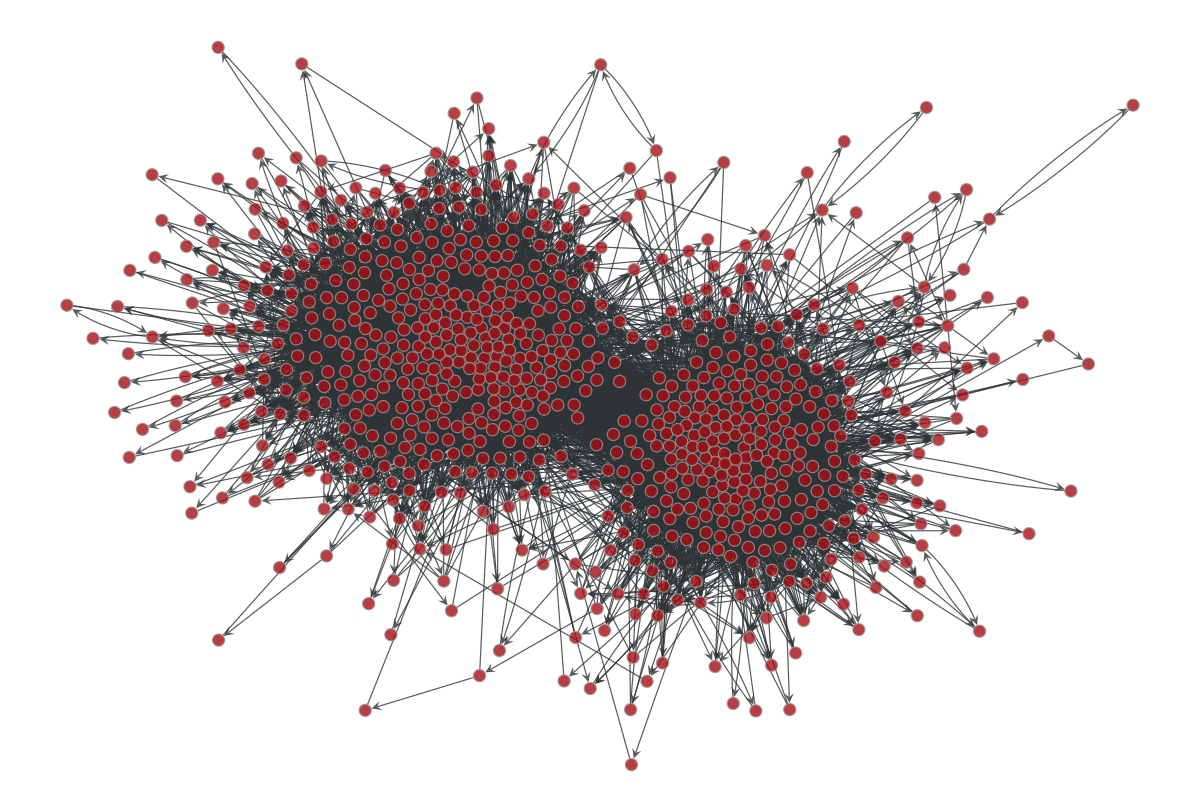

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x796eef75c9e0, at 0x796e55eb5cd0>

In [17]:
g = gt.collection.data["polblogs"]
g = gt.GraphView(g, vfilt=gt.label_largest_component(g))
g = gt.Graph(g, prune=True)
gt.graph_draw(g, g.vp.pos)

### Inferring different SBMs

Degree-corrected SBMs are preferred to focus on connectivity groups in networks with degree hetereogneity.

In [18]:
state = gt.minimize_blockmodel_dl(g, state_args={"deg_corr":True})
#state = gt.minimize_blockmodel_dl(g)

# Access the fitted partition (block labels for each vertex)
b = state.get_blocks()

print("Description length (Σ):", state.entropy())  # lower is better

Description length (Σ): 47497.157857672835


In [19]:
gt.minimize_nested_blockmodel_dl(g,state_args={"deg_corr":True})

<NestedBlockState object, with base <BlockState object with 793 blocks (16 nonempty), degree-corrected, for graph <Graph object, directed, with 793 vertices and 15841 edges, 4 internal vertex properties, 2 internal graph properties, at 0x796eef75c9e0>, at 0x796e4a807fb0>, and 11 levels of sizes [(793, 16), (16, 6), (6, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x796e5fd24dd0>

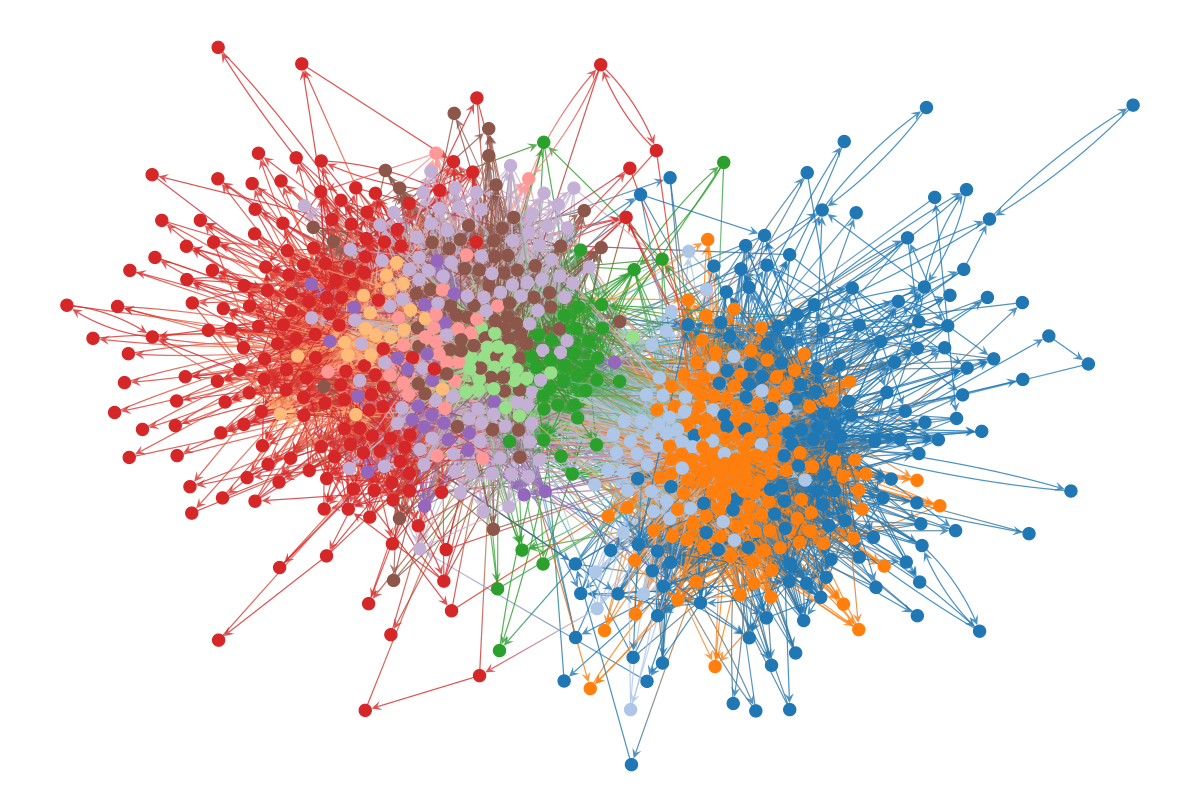

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x796eef75c9e0, at 0x796e4a8046b0>

In [20]:
state.draw(pos=g.vp.pos)

Nested-hierarchical SBM:

In [22]:
stateN = gt.minimize_nested_blockmodel_dl(g,state_args={"deg_corr":True})
print("Description length (Σ):", stateN.entropy())  # lower is better

Description length (Σ): 47196.606639549675


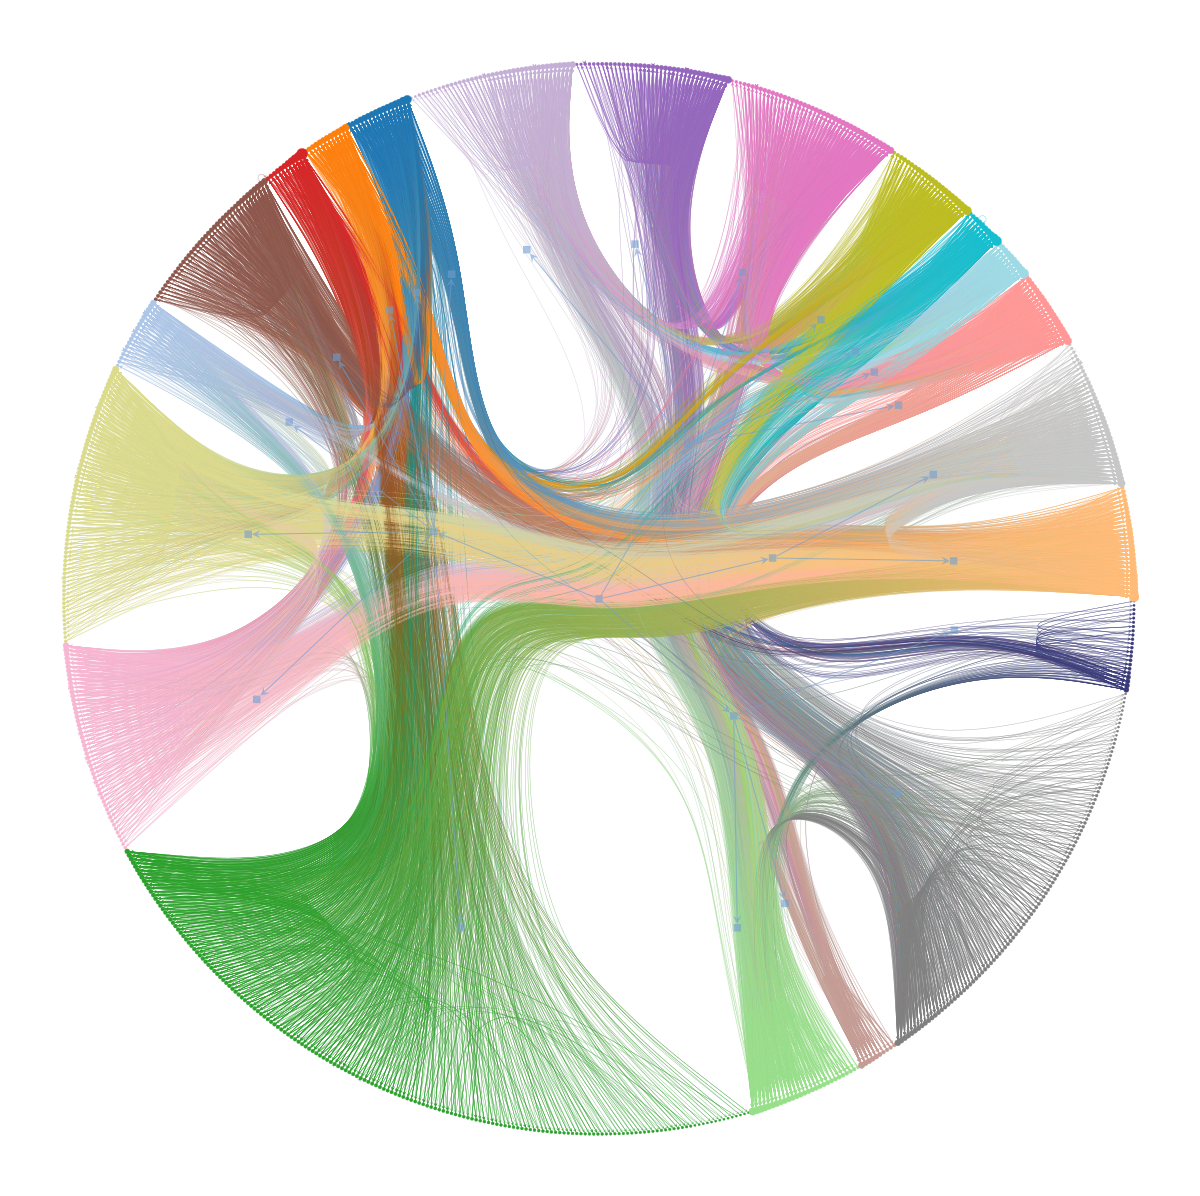

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x796eef75c9e0, at 0x796e4a866d20>,
 <GraphView object, directed, with 819 vertices and 818 edges, edges filtered by <EdgePropertyMap object with value type 'bool', for Graph 0x796e4a8361e0, at 0x796e4a866cc0>, vertices filtered by <VertexPropertyMap object with value type 'bool', for Graph 0x796e4a8361e0, at 0x796e3dc81010>, at 0x796e4a8361e0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x796e4a8361e0, at 0x796e701e1400>)

In [23]:
stateN.draw()

Inferred network with true B. Inferred logL=612.9774971950898 True logL=633.8973885886735


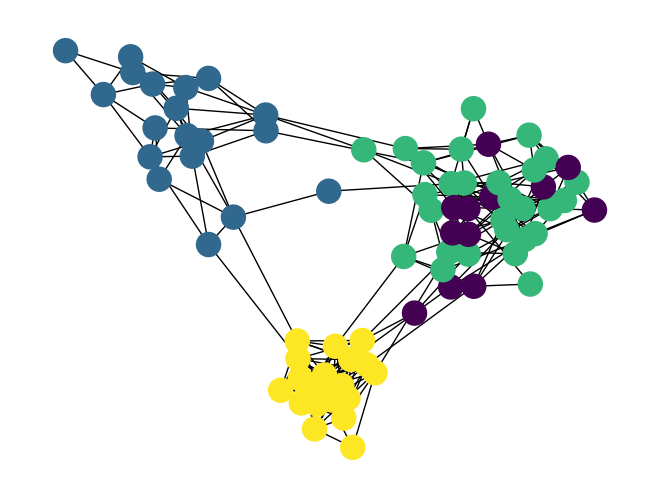

In [12]:
print("Inferred network with true B. Inferred logL="+str(logLs[3])+" True logL="+str(minusLogLB(Gsbm,btrue3)))
nx.draw(Gsbm,node_color=bbests[3],pos=layoutSBM)

- Poisson:

In [13]:
N=100
avgz=5
p=avgz/(N-1)
gp=nx.erdos_renyi_graph(N,p)

In [14]:
N=gp.number_of_nodes()
logPriors = [np.log(float(stirling(N,k+1,kind=2))) for k in range(N)]
logFactorial=[np.log(factorial(k+1)) for k in range(N)]


logLB=[]
logLs=[]
bbests=[]
Bmax=4
for Bf in np.arange(1,Bmax+1):
    print("Running B=",Bf," out of ",Bmax)
    logLB,bbestB=bestBrepeat(gp,Bf)
    #print(logLB)
    logLs.append(logLB)
    bbests.append(bbestB)
print(Bf,np.array(logLs)+logFactorial[:Bmax]+logPriors[:Bmax])

Running B= 1  out of  4
Running B= 2  out of  4
Running B= 3  out of  4
Running B= 4  out of  4
4 [918.33382355 939.75350134 952.67897091 961.96538386]
